# PROGRESS_LOG
- 2025-11-12: Plantilla inicial con TOC, config, loader robusto, EDA, utilidades, y secciones TODO.
- 2025-11-12: Engagement: agregado objetivo de clasificacion 'engagement_level' desde Selfreport_focus (terciles/mediana) y configuracion por defecto (proposito, y_reg, y_clf).

> Nota: No borrar entradas previas. Si mejoras algo, agrega nuevas celdas debajo y marca las antiguas como 'obsoletas'.


# Tabla de Contenidos
- [1. Introduccion y descripcion del problema](#intro)
- [2. Preparacion y exploracion de los datos](#eda)
  - [2.1 Configuracion](#config)
  - [2.1b Configuracion especifica (Engagement)](#config-eng)
  - [2.2 Carga de datos (robusta)](#load)
  - [2.3 EDA basica](#eda-basic)
  - [2.5 Objetivo de clasificacion (engagement_level)](#engagement-target)
  - [2.4 Preprocesamiento (TODO)](#preprocess)
- [3. Modelos de regresion](#regression)
- [4. Agrupamiento (Clustering)](#clustering)
- [5. Analisis de Componentes Principales (PCA)](#pca)
- [6. Clasificacion con Redes Neuronales Artificiales](#classification)
- [7. Conclusiones generales](#conclusions)
- [8. Articulo (formato publicacion)](#paper)
- [NEXT_ACTIONS](#next-actions)


<a id="intro"></a>
# 1. Introduccion y descripcion del problema
Cuaderno incremental, no destructivo e idempotente para el entregable 'Analisis de Datos del Socioformador con Tecnicas de IA'.

Resumen del dataset (NPFC-Test 23A):
- Contexto: interaccion humano-computadora en aprendizaje; senales EEG (Muse 2), fisiologicas (Empatica EmbracePlus) y faciales (Azure Kinect).
- Objetivo: evaluar concentracion y motivacion mediante multimodalidad (EEG, biomarcadores, gestos faciales, autorreporte).
- Variables: temporalidad (Timestamp, Test_Time, Task_Time, Task_Num, Task_Type), identificador (Subject_ID), autorreportes (Selfreport_valence/arousal/focus), deteccion facial y emociones (Face_Detection, resmasknet_*, svm_*), fisiologia (Temperature, EDA, BVP), EEG (bandas absolutas en TP9/AF7/AF8/TP10; RAW_*).

Completa parametros en Configuracion para adaptar el analisis.


<a id="eda"></a>
# 2. Preparacion y exploracion de los datos
Config, carga robusta del CSV y EDA minima (tipos, nulos, distribuciones, correlaciones, outliers).


<a id="config"></a>
## 2.1 Configuracion
Parametros idempotentes, semilla y librerias. No se escriben archivos externos por defecto.


In [61]:
# Parametros — completa segun tu actividad
ruta_csv = 'NPFC-Test_Database[FULL].csv'  # ajusta si es necesario
contexto_socioformador = ''  # breve contexto
proposito = ''  # proposito general del analisis
y_reg = None  # variable objetivo para regresion (opcional)
y_clf = None  # variable objetivo para clasificacion (opcional)
random_seed = 42
restricciones = ''  # p. ej., limites de tiempo o RAM

# Opciones de entorno y visualizacion
import warnings, os, sys, math, random
import numpy as np
import pandas as pd
from IPython.display import display
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

set_seed(random_seed)
print(f'Semilla fijada: {random_seed}')


Semilla fijada: 42


<a id="config-eng"></a>
### 2.1b Configuracion especifica (Engagement)
Establece proposito y variables objetivo por defecto si no estan definidas.


In [62]:
# Defaults para escenario de engagement
if not proposito:
    proposito = 'Estimar engagement (focus) a partir de senales EEG, fisiologicas y faciales para apoyar adaptacion de contenidos y alertas tempranas.'
print('Proposito:', proposito)

if y_reg is None:
    y_reg = 'Selfreport_focus'
print('y_reg =', y_reg)


Proposito: Estimar engagement (focus) a partir de senales EEG, fisiologicas y faciales para apoyar adaptacion de contenidos y alertas tempranas.
y_reg = Selfreport_focus


In [63]:
# Importaciones principales
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    HAS_SNS = True
except Exception:
    HAS_SNS = False
from io import StringIO
from pathlib import Path

if HAS_SNS:
    sns.set_context('notebook')
    sns.set_style('whitegrid')
print('Librerias cargadas. seaborn =', HAS_SNS)


Librerias cargadas. seaborn = True


<a id="load"></a>
## 2.2 Carga de datos (robusta)
Intenta automaticamente varios 'encoding' y separadores comunes. No falla si no encuentra el archivo; sugiere alternativas.


In [64]:
from typing import Optional, Tuple, Dict, Any
import csv

def sniff_delimiter(sample: str, default: str = ',') -> str:
    try:
        sniffer = csv.Sniffer()
        dialect = sniffer.sniff(sample, delimiters=[',',';','\t','|'])
        return dialect.delimiter
    except Exception:
        return default

def load_csv_robust(path: str) -> Tuple[Optional[pd.DataFrame], Dict[str, Any]]:
    meta = {'path': path, 'encoding_tried': [], 'sep_tried': [], 'used': {}}
    file = Path(path)
    if not file.exists():
        print(f'Archivo no encontrado: {path}')
        return None, meta
    encodings = ['utf-8', 'latin-1']
    seps = [',',';','	','|']
    sample = file.open('rb').read(8192)
    try:
        sample_txt = sample.decode('utf-8', errors='ignore')
    except Exception:
        sample_txt = ''
    guessed_sep = sniff_delimiter(sample_txt)
    if guessed_sep in seps:
        seps = [guessed_sep] + [s for s in seps if s != guessed_sep]
    for enc in encodings:
        for sep in seps:
            try:
                df_try = pd.read_csv(path, sep=sep, encoding=enc, engine='python')
                meta['used'] = {'encoding': enc, 'sep': sep}
                print(f'Leido con encoding="{enc}" sep="{sep}"  shape={df_try.shape}')
                return df_try, meta
            except Exception:
                meta['encoding_tried'].append(enc)
                meta['sep_tried'].append(sep)
                continue
    print('No se pudo leer el CSV con combinaciones estandar. Revisa separador/encoding.')
    return None, meta

df, load_meta = load_csv_robust(ruta_csv)
if df is not None:
    display(pd.DataFrame({'Archivo':[load_meta['path']], 'Encoding':[load_meta.get('used',{}).get('encoding')], 'Separador':[load_meta.get('used',{}).get('sep')], 'Filas':[df.shape[0]], 'Columnas':[df.shape[1]]}))
else:
    print('Pendiente: validar ruta/encoding/separador del archivo de entrada.')


Leido con encoding="utf-8" sep=","  shape=(47916, 54)


,Archivo,Encoding,Separador,Filas,Columnas
0,NPFC-Test_Database[FULL].csv,utf-8,",",47916,54


<a id="eda-basic"></a>
## 2.3 EDA basica
Tipos y % nulos, resumen de tamano/memoria, cardinalidad de categoricas, histogramas/boxplots y correlacion.


In [65]:
def memory_mb(df: pd.DataFrame) -> float:
    return float(df.memory_usage(deep=True).sum()) / (1024**2)

if df is not None:
    dtypes = df.dtypes.astype(str)
    nulls = df.isna().mean()*100
    nunique = df.nunique(dropna=False)
    overview = pd.DataFrame({'dtype': dtypes, '%nulls': nulls.round(2), 'n_unique': nunique}).sort_index()
    display(overview.head(50))

    n_rows, n_cols = df.shape
    mem = memory_mb(df)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()
    summary = pd.DataFrame([{'rows': n_rows, 'cols': n_cols, 'memory_MB': round(mem,2), 'num_cols': len(num_cols), 'cat_cols': len(cat_cols)}])
    display(summary)

    if len(cat_cols) > 0:
        card = pd.DataFrame({'col': cat_cols, 'n_unique': [df[c].nunique(dropna=False) for c in cat_cols]}).sort_values('n_unique', ascending=False)
        display(card.head(20))
else:
    print('Sin datos cargados para EDA.')


,dtype,%nulls,n_unique
Alpha_AF7,float64,2.97,29616
Alpha_AF8,float64,2.97,33095
Alpha_TP10,float64,2.97,38000
Alpha_TP9,float64,2.97,38200
BVP,float64,2.25,46823
Beta_AF7,float64,2.97,29745
Beta_AF8,float64,2.97,33231
Beta_TP10,float64,2.97,38265
Beta_TP9,float64,2.97,38466
Delta_AF7,float64,2.97,29760


,rows,cols,memory_MB,num_cols,cat_cols
0,47916,54,29.6,50,4


,col,n_unique
0,Timestamp,44464
2,Test_Time,2684
3,Task_Time,253
1,Subject_ID,42


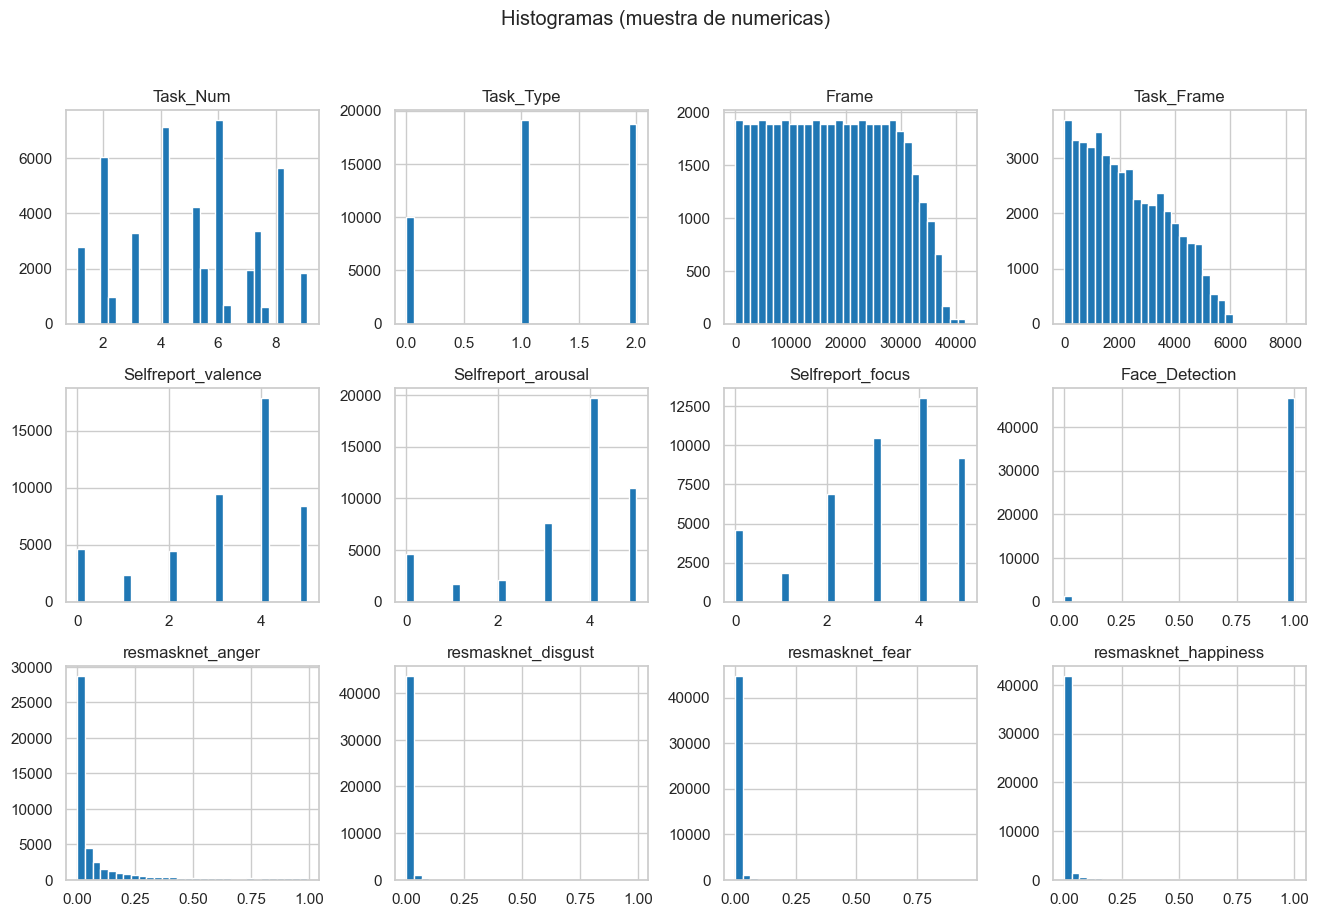

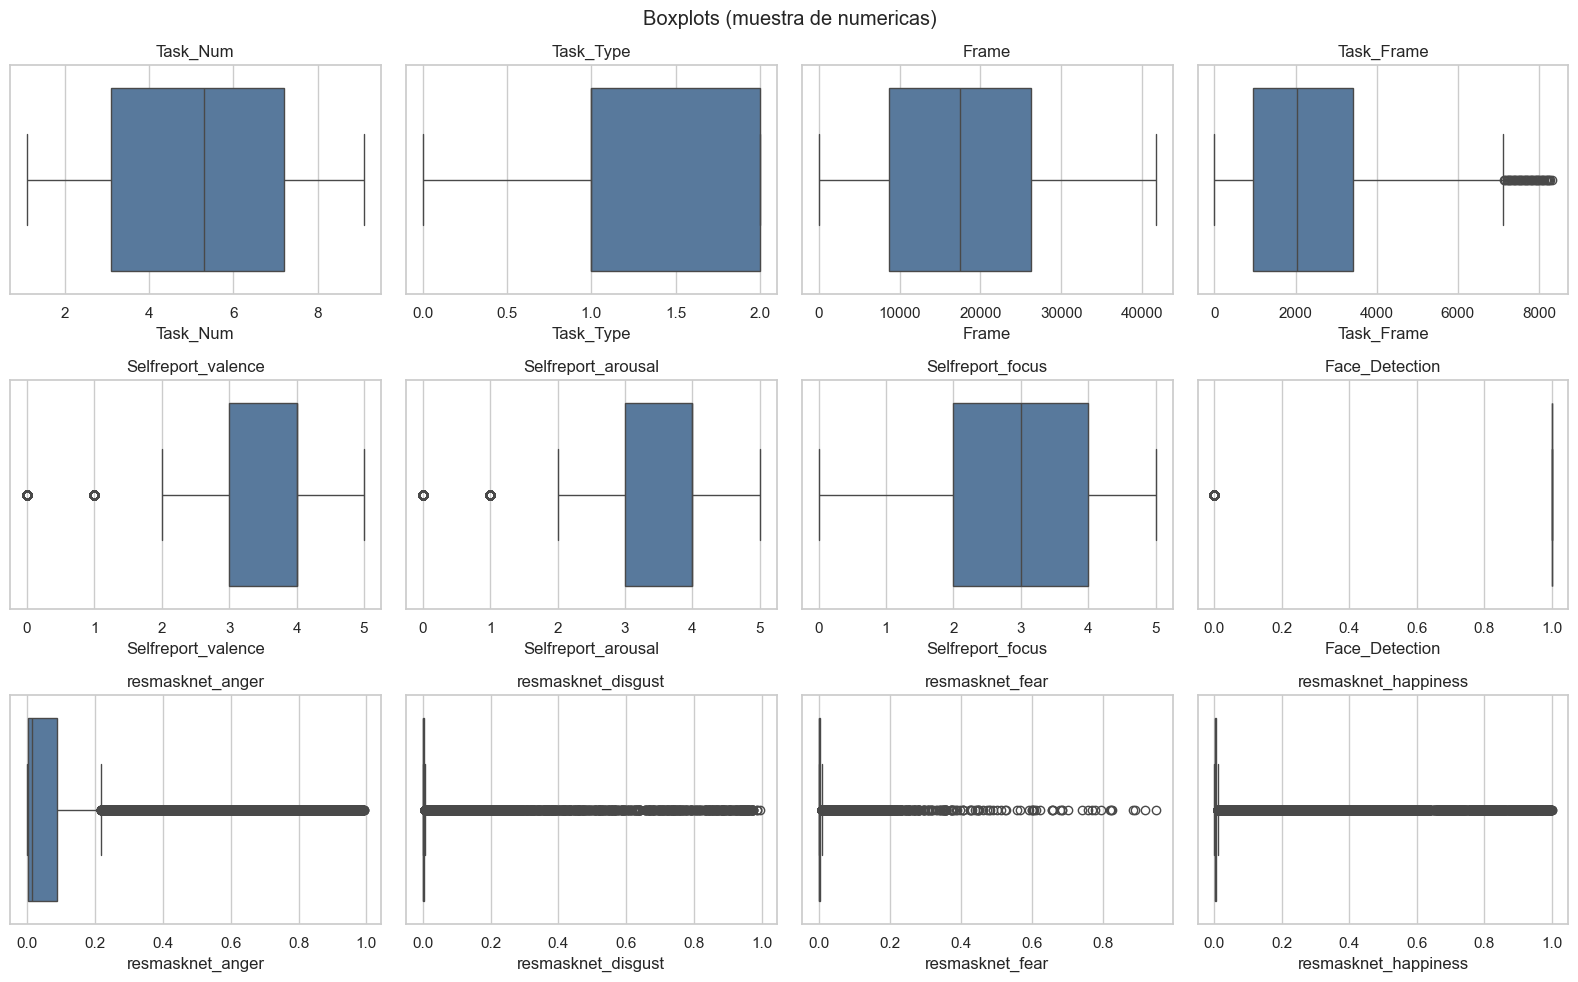

In [66]:
# Distribuciones y outliers (muestra)
if df is not None:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols_plot = num_cols[:12]
    if cols_plot:
        df[cols_plot].hist(figsize=(16, 10), bins=30, layout=(max(1, math.ceil(len(cols_plot)/4)), 4))
        plt.suptitle('Histogramas (muestra de numericas)')
        plt.show()
        n_rows_fig = max(1, math.ceil(len(cols_plot)/4))
        fig, axes = plt.subplots(nrows=n_rows_fig, ncols=4, figsize=(16, 10))
        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        for ax, col in zip(axes, cols_plot):
            if HAS_SNS:
                sns.boxplot(x=df[col], ax=ax, color='#4C78A8')
            else:
                ax.boxplot(df[col].dropna().values, vert=False)
            ax.set_title(col)
        plt.suptitle('Boxplots (muestra de numericas)')
        plt.tight_layout()
        plt.show()
    else:
        print('No se encontraron columnas numericas para visualizar.')


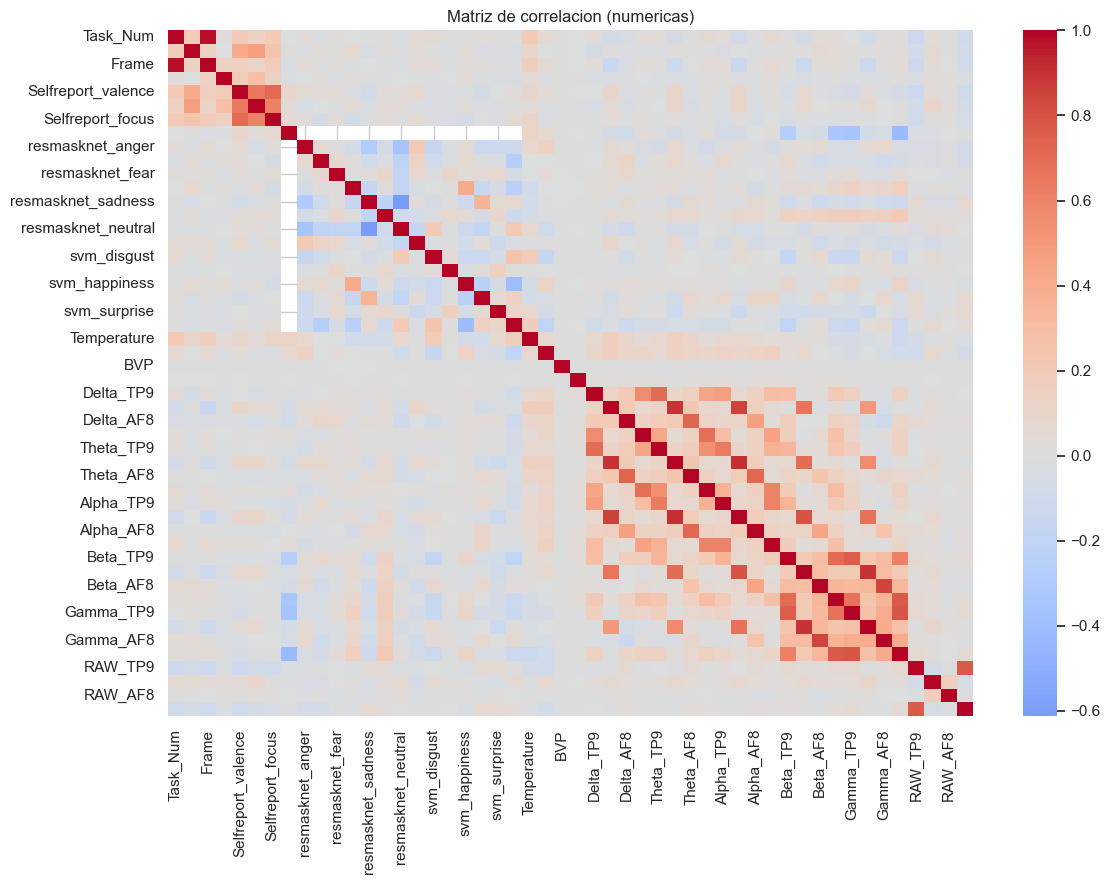

In [67]:
# Heatmap de correlacion (numericas)
if df is not None:
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) >= 2:
        corr = df[num_cols].corr()
        plt.figure(figsize=(12, 9))
        if HAS_SNS:
            sns.heatmap(corr, cmap='coolwarm', center=0)
        else:
            plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
            plt.colorbar()
            plt.xticks(range(len(num_cols)), num_cols, rotation=90)
            plt.yticks(range(len(num_cols)), num_cols)
        plt.title('Matriz de correlacion (numericas)')
        plt.tight_layout()
        plt.show()
    else:
        print('Insuficientes columnas numericas para correlacion.')


<a id="engagement-target"></a>
## 2.5 Objetivo de clasificacion (engagement_level)
Derivacion desde Selfreport_focus usando terciles; fallback a mediana si hay pocos valores unicos.


engagement_level creado usando: qcut terciles
umbrales: [3. 4.]


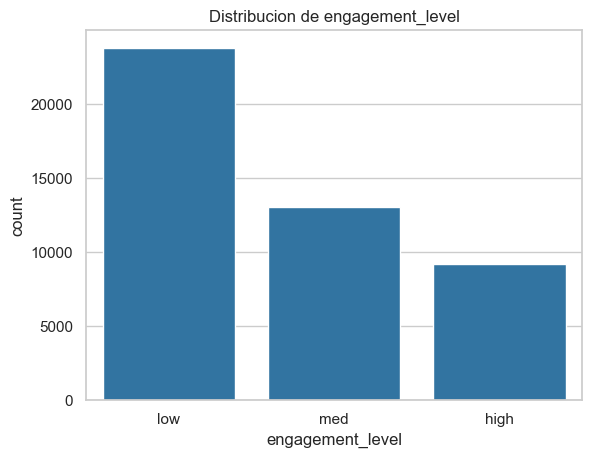

y_clf = engagement_level


In [68]:
if df is not None and 'Selfreport_focus' in df.columns:
    s = df['Selfreport_focus'].astype(float)
    labels = ['low','med','high']
    method = None
    thresholds = None
    try:
        q = s.quantile([0.3333, 0.6667]).values
        df['engagement_level'] = pd.qcut(s, q=[0, 0.3333, 0.6667, 1], labels=labels, duplicates='drop')
        if getattr(df['engagement_level'], 'cat', None) is None or len(df['engagement_level'].cat.categories) < 3:
            raise ValueError('Insuficientes valores unicos para terciles')
        method = 'qcut terciles'
        thresholds = q
    except Exception as e:
        med = float(s.median())
        df['engagement_level'] = pd.cut(s, bins=[-np.inf, med, np.inf], labels=['low','high'])
        method = 'median split'
        thresholds = [med]
    print('engagement_level creado usando:', method)
    print('umbrales:', thresholds)
    try:
        if HAS_SNS:
            order = ['low','med','high'] if 'med' in df['engagement_level'].astype(str).unique() else ['low','high']
            sns.countplot(x='engagement_level', data=df, order=order)
        else:
            counts = df['engagement_level'].value_counts().sort_index()
            plt.bar(counts.index.astype(str), counts.values)
        plt.title('Distribucion de engagement_level')
        plt.show()
    except Exception as e:
        print('No se pudo graficar distribucion:', e)
else:
    print('No se puede crear engagement_level: df no cargado o falta Selfreport_focus')

if 'y_clf' in globals() and y_clf is None:
    y_clf = 'engagement_level'
print('y_clf =', y_clf)


<a id="preprocess"></a>
## 2.4 Preprocesamiento (TODO)
Imputacion, codificacion de categoricas, escalado de numericas via ColumnTransformer/Pipeline.


<a id="regression"></a>
# 3. Modelos de regresion
- Estado: pendiente de y_reg.
- Metricas objetivo: R2, RMSE, MAE; diagnosticos (residuos, QQ-plot).


In [69]:
# Placeholder regresion — no ejecuta si y_reg es None
if y_reg is None:
    print('TODO: definir y_reg para entrenar y evaluar modelos de regresion.')
else:
    print(f'Variable objetivo (regresion): {y_reg}')
    # TODO: split, Pipeline(preprocess + modelo), metricas y graficos


Variable objetivo (regresion): Selfreport_focus


<a id="clustering"></a>
# 4. Agrupamiento (Clustering)
- Estado: pendiente (Sesion 3).
- Objetivos: K-means/DBSCAN, codo/silhouette; visualizacion 2D con PCA/t-SNE.


<a id="pca"></a>
# 5. Analisis de Componentes Principales (PCA)
- Estado: pendiente (Sesion 2).
- Entregables: varianza explicada acumulada, scatter 2D, cargas por componente.


<a id="classification"></a>
# 6. Clasificacion con Redes Neuronales Artificiales
- Estado: pendiente de y_clf.
- Metricas: accuracy, matriz de confusion, ROC/AUC (binaria) o macro AUC (multiclase), precision/recall/F1.


In [70]:
# Placeholder clasificacion — no ejecuta si y_clf es None
if y_clf is None:
    print('TODO: definir y_clf para entrenar y evaluar un MLP.')
else:
    print(f'Variable objetivo (clasificacion): {y_clf}')
    # TODO: split, Pipeline(preprocess + MLP), metricas, ROC macro y matriz de confusion


Variable objetivo (clasificacion): engagement_level


<a id="conclusions"></a>
# 7. Conclusiones generales
- Estado: se completara al finalizar los analisis.
- Incluir: hallazgos clave, implicaciones para el socioformador, riesgos/limitaciones y siguientes pasos.


<a id="paper"></a>
# 8. Articulo (formato publicacion)
Estructura a mantener y completar incrementalmente:
- Resumen (abstract)
- Metodologia
- Resultados clave
- Discusion e implicaciones
- Limitaciones y trabajo futuro


In [71]:
# Utilidades
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, roc_auc_score, roc_curve

def evaluate_regression(y_true, y_pred) -> pd.DataFrame:
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return pd.DataFrame([{'R2': r2, 'RMSE': rmse, 'MAE': mae}])

def plot_confusion(y_true, y_pred, labels=None, title='Matriz de confusion'):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6,5))
    if 'sns' in globals() and HAS_SNS:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    else:
        plt.imshow(cm, cmap='Blues')
        for (i,j), val in np.ndenumerate(cm):
            plt.text(j, i, int(val), ha='center', va='center')
    plt.title(title)
    plt.xlabel('Prediccion')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_score, pos_label=None, multi_class='ovr', average='macro', title='ROC/AUC'):
    try:
        auc = roc_auc_score(y_true, y_score, multi_class=multi_class, average=average)
        print(f'AUC: {auc:.3f}')
    except Exception as e:
        print('No se pudo calcular AUC:', e)


<a id="next-actions"></a>
# NEXT_ACTIONS
- [ ] Confirmar ruta_csv, contexto_socioformador y proposito.
- [ ] Completar Preprocesamiento (imputacion, codificacion, escalado).
- [ ] Anadir PCA (varianza + cargas + scatter 2D).
- [ ] Implementar Clustering (K-means/DBSCAN + codo/silhouette).
- [ ] Si aplica, ejecutar regresion usando y_reg con metricas y diagnosticos.
- [ ] Si aplica, entrenar MLP para y_clf con metricas (ROC/AUC macro).
- [ ] Redactar conclusiones y avanzar en la seccion de Articulo.


# Sesion 2 (adiciones rapidas)
Esta seccion agrega implementaciones basicas, idempotentes y ligeras para laptop (<=16GB RAM).


In [72]:
# Limites de ejecucion para laptop
N_JOBS = 1  # usar un solo job/hilo en modelos que lo soporten
MAX_PLOT_POINTS = 5000  # limite de puntos para scatter
print('N_JOBS =', N_JOBS)


N_JOBS = 1


### 2.4.1 Preprocesamiento (implementacion)
Construye listas de variables, excluye identificadores y objetivos, y aplica imputacion+escalado (numericas) y imputacion+OneHot (categoricas).


In [73]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

def get_feature_sets(df: pd.DataFrame, targets: list) -> tuple[list, list]:
    drop_cols = set(targets) | set(['Subject_ID','Timestamp'])
    base = df.drop(columns=[c for c in df.columns if c in drop_cols], errors='ignore')
    num_cols = base.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = base.select_dtypes(exclude=[np.number]).columns.tolist()
    return num_cols, cat_cols

def _get_ohe():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)       # sklearn < 1.2

def build_preprocessor(num_cols: list, cat_cols: list) -> ColumnTransformer:
    num_pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    cat_pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', _get_ohe())])
    pre = ColumnTransformer(transformers=[('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)], remainder='drop')
    return pre

X_proc = None; y_reg_vec = None; y_clf_vec = None; pre = None
if df is not None:
    # Evitar fuga: si y_clf = engagement_level (derivado de Selfreport_focus), excluimos todos los Selfreport_* como features
    targets = []
    if y_reg is not None and y_reg in df.columns:
        targets.append(y_reg)
    if 'engagement_level' in df.columns:
        targets.append('Selfreport_focus')
    # Para clasificacion, tambien evitar usar otros autorreportes por defecto
    if 'engagement_level' in df.columns:
        targets += [c for c in df.columns if c.startswith('Selfreport_')]
    num_cols, cat_cols = get_feature_sets(df, list(set(targets)))
    pre = build_preprocessor(num_cols, cat_cols)
    # Construir X e y segun disponibilidad
    X = df[num_cols + cat_cols].copy() if (num_cols or cat_cols) else pd.DataFrame(index=df.index)
    y_reg_vec = df[y_reg].values if (y_reg is not None and y_reg in df.columns) else None
    y_clf_vec = df['engagement_level'].astype(str).values if ('engagement_level' in df.columns) else None
    # Transformar
    X_proc = pre.fit_transform(X)
    print('Features: num =', len(num_cols), ', cat =', len(cat_cols), '-> X_proc shape =', getattr(X_proc, 'shape', None))
else:
    print('Preprocesamiento omitido: df no cargado')


Features: num = 47 , cat = 3 -> X_proc shape = (47916, 2985)


### 5.1 PCA rapido (10 componentes)
Se ajusta PCA sobre X preprocesado. Graficos: varianza explicada acumulada y scatter 2D (PC1 vs PC2).


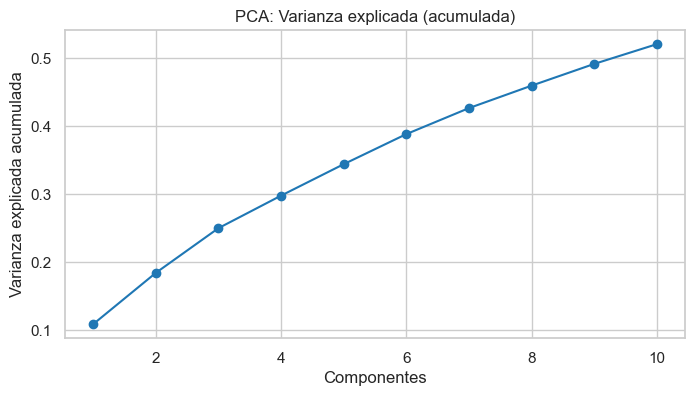

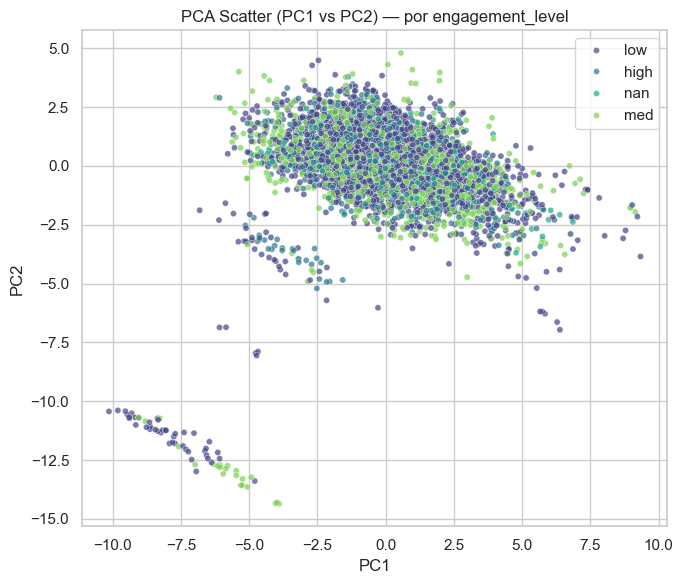

In [74]:
from sklearn.decomposition import PCA

pca = None; X_pca = None
if 'X_proc' in globals() and X_proc is not None and getattr(X_proc, 'shape', (0,0))[0] > 0:
    n_comp = min(10, X_proc.shape[1]) if X_proc.shape[1] > 0 else 0
    if n_comp >= 2:
        pca = PCA(n_components=n_comp, random_state=random_seed)
        X_pca = pca.fit_transform(X_proc)
        # Varianza explicada
        evr = pca.explained_variance_ratio_
        plt.figure(figsize=(8,4))
        plt.plot(np.arange(1, len(evr)+1), np.cumsum(evr), marker='o')
        plt.xlabel('Componentes')
        plt.ylabel('Varianza explicada acumulada')
        plt.title('PCA: Varianza explicada (acumulada)')
        plt.grid(True)
        plt.show()
        # Scatter 2D coloreado
        color = None
        title = 'PCA Scatter (PC1 vs PC2)'
        if 'y_clf_vec' in globals() and y_clf_vec is not None:
            color = y_clf_vec
            title += ' — por engagement_level'
        elif 'y_reg_vec' in globals() and y_reg_vec is not None:
            color = y_reg_vec
            title += ' — por Selfreport_focus'
        idx_plot = np.arange(X_pca.shape[0])
        if X_pca.shape[0] > MAX_PLOT_POINTS:
            rng = np.random.default_rng(random_seed)
            idx_plot = rng.choice(X_pca.shape[0], size=MAX_PLOT_POINTS, replace=False)
        plt.figure(figsize=(7,6))
        if 'sns' in globals() and HAS_SNS and color is not None:
            try:
                sns.scatterplot(x=X_pca[idx_plot,0], y=X_pca[idx_plot,1], hue=np.array(color)[idx_plot], s=20, alpha=0.7, palette='viridis')
            except Exception:
                plt.scatter(X_pca[idx_plot,0], X_pca[idx_plot,1], c=np.array(color)[idx_plot], s=12, alpha=0.7)
        else:
            c = None if color is None else np.array(color)[idx_plot]
            plt.scatter(X_pca[idx_plot,0], X_pca[idx_plot,1], c=c, s=12, alpha=0.7)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        print('PCA omitido: insuficientes features (n_comp < 2).')
else:
    print('PCA omitido: X_proc no disponible.')


### Hotfix — Preprocesamiento (compatibilidad scikit-learn 1.4+)
Se redefine `build_preprocessor` para usar `sparse_output=False` (>=1.2) y caer a `sparse=False` en versiones anteriores. Luego se reconstruye X_proc.


In [75]:
# Redefinicion compatible de OneHotEncoder y reconstruccion de X_proc
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def _get_ohe():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sklearn >= 1.2
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)       # sklearn < 1.2

def build_preprocessor(num_cols: list, cat_cols: list) -> ColumnTransformer:
    num_pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    cat_pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', _get_ohe())])
    pre = ColumnTransformer(transformers=[('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)], remainder='drop')
    return pre

# Reconstruir con la version compatible
if df is not None:
    targets = []
    if y_reg is not None and y_reg in df.columns:
        targets.append(y_reg)
    if 'engagement_level' in df.columns:
        targets.append('Selfreport_focus')
        targets += [c for c in df.columns if c.startswith('Selfreport_')]
    num_cols, cat_cols = get_feature_sets(df, list(set(targets)))
    pre = build_preprocessor(num_cols, cat_cols)
    X = df[num_cols + cat_cols].copy() if (num_cols or cat_cols) else pd.DataFrame(index=df.index)
    y_reg_vec = df[y_reg].values if (y_reg is not None and y_reg in df.columns) else None
    y_clf_vec = df['engagement_level'].astype(str).values if ('engagement_level' in df.columns) else None
    X_proc = pre.fit_transform(X)
    print('Hotfix aplicado. X_proc shape =', getattr(X_proc, 'shape', None))
else:
    print('Hotfix: df no cargado')


Hotfix aplicado. X_proc shape = (47916, 2985)


## Baselines rapidos (regresion y clasificacion)
Modelos ligeros con Pipeline(preprocesamiento+modelo) respetando N_JOBS=1. Evitan fuga de informacion.


### Baseline de Regresion — Selfreport_focus (Ridge)
Incluye split train/test, ajuste con ColumnTransformer y metricas R2, RMSE, MAE + grafico de residuos y QQ-plot.


In [76]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Baseline de regresion
if df is not None and y_reg is not None and y_reg in df.columns:
    # Features y target
    targets = [y_reg]
    num_cols, cat_cols = get_feature_sets(df, targets)
    pre_reg = build_preprocessor(num_cols, cat_cols)
    X = df[num_cols + cat_cols].copy()
    y = df[y_reg].astype(float).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, shuffle=True)

    pipe_reg = Pipeline(steps=[('pre', pre_reg), ('model', Ridge(alpha=1.0))])
    pipe_reg.fit(X_train, y_train)
    y_pred = pipe_reg.predict(X_test)
    # Metricas
    res = evaluate_regression(y_test, y_pred)
    display(res)
    # Residuos
    resid = y_test - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, resid, s=12, alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Prediccion')
    plt.ylabel('Residuo')
    plt.title('Residuos vs Prediccion (Ridge)')
    plt.tight_layout()
    plt.show()
    # QQ-plot (si scipy disponible)
    try:
        from scipy import stats
        plt.figure(figsize=(5,5))
        stats.probplot(resid, dist='norm', plot=plt)
        plt.title('QQ-plot de residuos')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('QQ-plot omitido (scipy no disponible):', e)
else:
    print('Regresion pendiente: df/y_reg no definidos o no presentes en el dataset.')


ValueError: Input y contains NaN.

### Hotfix — Regresion con y_reg con NaN en el objetivo
Filtra filas con `y_reg` nulo/no numerico antes del split.


In [ ]:
# Reintento de baseline de regresion filtrando NaN en el objetivo
from sklearn.linear_model import Ridge

if df is not None and y_reg is not None and y_reg in df.columns:
    targets = [y_reg]
    num_cols, cat_cols = get_feature_sets(df, targets)
    pre_reg = build_preprocessor(num_cols, cat_cols)
    X_all = df[num_cols + cat_cols].copy()
    y_ser = pd.to_numeric(df[y_reg], errors='coerce')
    mask = y_ser.notna()
    dropped = int((~mask).sum())
    if dropped > 0:
        print(f'Se excluyen {dropped} filas con y_reg NaN/no numerico.')
    X = X_all.loc[mask]
    y = y_ser.loc[mask].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, shuffle=True)
    pipe_reg = Pipeline(steps=[('pre', pre_reg), ('model', Ridge(alpha=1.0))])
    pipe_reg.fit(X_train, y_train)
    y_pred = pipe_reg.predict(X_test)
    display(evaluate_regression(y_test, y_pred))
else:
    print('Regresion (hotfix) pendiente: df/y_reg no validos.')


### Baseline de Clasificacion — engagement_level (LogisticRegression)
Incluye split estratificado, matriz de confusion, accuracy y F1 macro; ROC/AUC macro si hay probabilidades.


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Baseline de clasificacion
if df is not None and 'engagement_level' in df.columns:
    y = df['engagement_level'].astype(str)
    # Evitar fuga: excluir todos los Selfreport_*
    targets = [c for c in df.columns if c.startswith('Selfreport_')]
    num_cols, cat_cols = get_feature_sets(df, targets)
    pre_clf = build_preprocessor(num_cols, cat_cols)
    X = df[num_cols + cat_cols].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

    clf = LogisticRegression(solver='liblinear', multi_class='ovr', n_jobs=N_JOBS, max_iter=1000)
    pipe_clf = Pipeline(steps=[('pre', pre_clf), ('model', clf)])
    pipe_clf.fit(X_train, y_train)
    y_pred = pipe_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average='macro')
    print({'accuracy': round(acc,3), 'f1_macro': round(f1m,3)})
    # Confusion matrix
    try:
        plot_confusion(y_test, y_pred, title='Matriz de confusion (LogReg)')
    except Exception as e:
        print('No se pudo graficar la matriz de confusion:', e)
    # ROC/AUC macro (si predict_proba disponible)
    try:
        y_score = pipe_clf.predict_proba(X_test)
        plot_roc(y_test, y_score, multi_class='ovr', average='macro', title='ROC/AUC macro (LogReg)')
    except Exception as e:
        print('ROC/AUC omitido:', e)
else:
    print('Clasificacion pendiente: df/engagement_level no disponibles.')
